In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt

from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation, add_pulsation, evaluate_pulsations
import jax.numpy as jnp
from transformer_payne import Blackbody, TransformerPayne
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.2, so it will not be used.
  warnings.warn(


# Cepheid

In this notebook, we demonstrate how to use SPICE to model a Cepheid variable star.
Cepheids are pulsating variable stars that exhibit periodic changes in radius, temperature, and luminosity. We'll use data from Delta Cephei, a well-known prototype of this class.

We are going to use SPIPS3 (https://github.com/amerand/SPIPS3) to obtain the radius, temperature and log g changes with the phase of the pulsation.

We'll visualize the pulsation parameters (radius, effective temperature, and surface gravity) over the star's phase cycle, then use SPICE to create a 3D model of the star and generate synthetic spectra at different phases of pulsation.

To obtain a realistic result, let's use the ```TransformerPayne``` emulator.

Note that the results obtained by A. Mérand in SPIPS3 are calculated using ATLAS9 atmospheres, therefore we might get slightly different results.

In [2]:
tp = TransformerPayne.download()
b = Blackbody()

In [3]:
# obs_data = Table.read('~/Documents/spips/SPIPS3/DELTA_CEP/delta_cep.fits', format='fits', hdu=1);
pulsation_data = Table.read('delta_cep.fits', format='fits', hdu=2);
#pulsation_data = Table.read('delta_cep.fits', format='fits', hdu=2);

In [4]:
model_data = Table.read('delta_cep.fits', format='fits', hdu=1)

In [5]:
from collections import defaultdict

obs_phases = defaultdict(list)
obs_magnitudes = defaultdict(list)
obs_magnitudes_err = defaultdict(list)
obs_colors = defaultdict(list)
obs_colors_err = defaultdict(list)

for r in model_data:
    if 'mag' in r['OBS']:
        filter = r['OBS'].split('|')[1]
        obs_phases[filter].append(r['PHASE'])
        obs_magnitudes[filter].append(r['MEAS'])
        obs_magnitudes_err[filter].append(r['ERR'])
    if 'color' in r['OBS']:
        filter = r['OBS'].split('|')[1]
        obs_phases[filter].append(r['PHASE'])
        obs_colors[filter].append(r['MEAS'])
        obs_colors_err[filter].append(r['ERR'])

In [6]:
import numpy as np
def mjd_to_phase(mjd):
    """
    Convert MJD to phase using the period and reference epoch from model_data.
    
    Parameters
    ----------
    mjd : float or array-like
        Modified Julian Date(s) to convert to phase
        
    Returns
    -------
    float or array-like
        Phase(s) corresponding to the input MJD(s)
    """
    period = model_data['PERIOD'][0]  # Get period from model data
    ref_epoch = model_data['REF_EPOCH'][0]  # Get reference epoch from model data
    
    # Calculate phase using the formula: (MJD - ref_epoch) / period
    phase = (mjd - ref_epoch) / period
    
    # Normalize phase to be between 0 and 1
    phase = phase - np.floor(phase)
    
    return phase


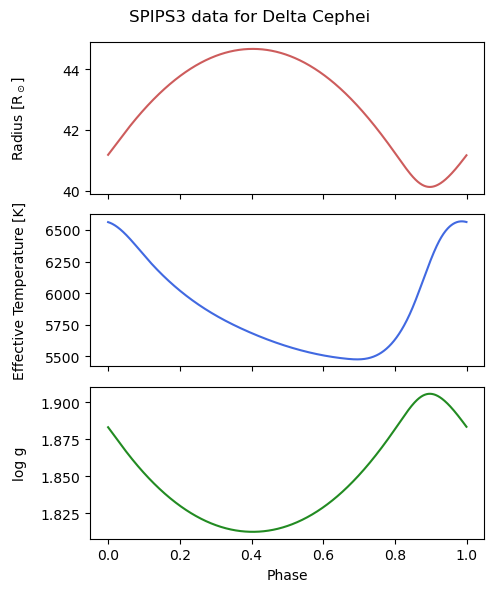

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(5, 6), sharex=True)
fig.suptitle('SPIPS3 data for Delta Cephei')

# Plot radius
axs[0].plot(pulsation_data['PHASE'], pulsation_data['R'], color='indianred')
axs[0].set_ylabel(r'Radius [R$_\odot$]', labelpad=10)

# Plot effective temperature
axs[1].plot(pulsation_data['PHASE'], pulsation_data['Teff'], color='royalblue')
axs[1].set_ylabel('Effective Temperature [K]', labelpad=10)

# Plot log g (note: correcting the y-label from previous cell)
axs[2].plot(pulsation_data['PHASE'], pulsation_data['logg'], color='forestgreen')
axs[2].set_xlabel('Phase')
axs[2].set_ylabel('log g', labelpad=10)

# Ensure y-labels are aligned
fig.align_ylabels(axs)

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
print('Starting radius:', pulsation_data['R'][0], r'R [R$_\odot$]')
print('Starting effective temperature:', pulsation_data['Teff'][0], 'K')
print('Starting log g:', pulsation_data['logg'][0])

Starting radius: 41.178368 R [R$_\odot$]
Starting effective temperature: 6562.0015 K
Starting log g: 1.8831891


Let's fit a Fourier series approximation for the radius-phase relationship modelled with SPIPS3.

<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\o'
/jobfs/144999564.gadi-pbs/ipykernel_1138398/3741888319.py:46: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Radius [R$_\odot$]')


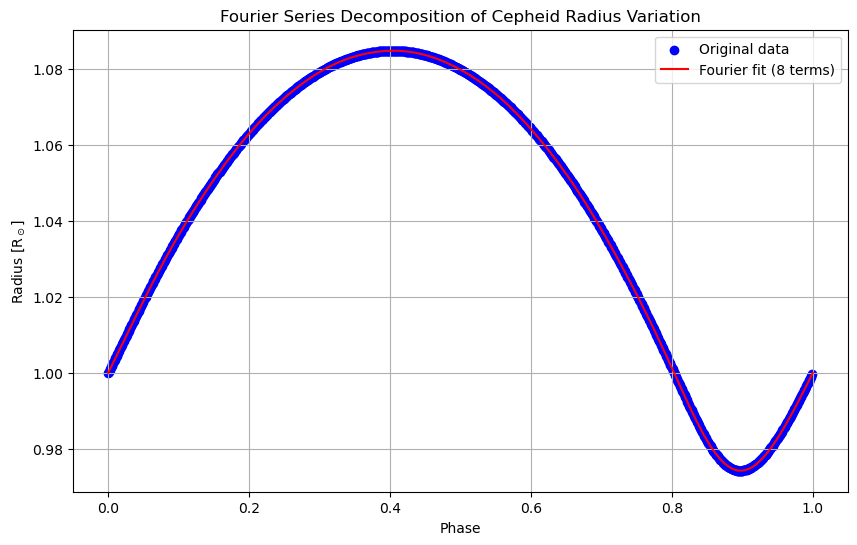

Mean radius (a0): 1.0420 R_sun
Fourier coefficients:
Term 1: amplitude = 0.0508, phase = 2.5278 rad
Term 2: amplitude = 0.0108, phase = 1.8932 rad
Term 3: amplitude = 0.0036, phase = 1.2427 rad
Term 4: amplitude = 0.0014, phase = 0.5484 rad
Term 5: amplitude = 0.0006, phase = -0.2436 rad
Term 6: amplitude = 0.0003, phase = -1.1542 rad
Term 7: amplitude = 0.0002, phase = -2.1086 rad
Term 8: amplitude = 0.0001, phase = -3.0076 rad

Fourier series parameters for SPICE:
[[ 5.08410023e-02  2.52778534e+00]
 [ 1.07786710e-02  1.89320108e+00]
 [ 3.64884277e-03  1.24266937e+00]
 [ 1.44494986e-03  5.48410078e-01]
 [ 6.17318686e-04 -2.43612157e-01]
 [ 2.88661671e-04 -1.15420866e+00]
 [ 1.52119818e-04 -2.10861958e+00]
 [ 8.50754672e-05 -3.00762780e+00]]


In [9]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Extract radius and phase data
radius = np.array(pulsation_data['R']/pulsation_data['R'][0])
phases = np.array(pulsation_data['PHASE'])

# Sort data by phase to ensure proper fitting
sort_idx = np.argsort(phases)
phases = phases[sort_idx]
radius = radius[sort_idx]

# Define the Fourier series function
def fourier_series(x, a0, *args):
    """
    Fourier series function with a0 as the mean and args as pairs of (a_n, b_n) coefficients.
    """
    n_terms = len(args) // 2
    result = a0
    for i in range(n_terms):
        a_i = args[2*i]
        b_i = args[2*i+1]
        result += a_i * np.cos(2 * np.pi * (i+1) * x) + b_i * np.sin(2 * np.pi * (i+1) * x)
    return result

# Fit the Fourier series to the radius data
# Start with 4 terms (8 parameters + a0)
n_terms = 8
initial_guess = [np.mean(radius)] + [0.0] * (2 * n_terms)
params, params_covariance = optimize.curve_fit(fourier_series, phases, radius, p0=initial_guess)

# Extract the fitted parameters
a0 = params[0]
fourier_coeffs = params[1:]

# Prepare for visualization
phase_fine = np.linspace(0, 1, 1000)
radius_fit = fourier_series(phase_fine, *params)

# Plot the original data and the Fourier fit
plt.figure(figsize=(10, 6))
plt.scatter(phases, radius, color='blue', label='Original data')
plt.plot(phase_fine, radius_fit, color='red', label=f'Fourier fit ({n_terms} terms)')
plt.xlabel('Phase')
plt.ylabel('Radius [R$_\odot$]')
plt.title('Fourier Series Decomposition of Cepheid Radius Variation')
plt.legend()
plt.grid(True)
plt.show()

# Print the Fourier coefficients
print(f"Mean radius (a0): {a0:.4f} R_sun")
print("Fourier coefficients:")
for i in range(n_terms):
    a_i = fourier_coeffs[2*i]
    b_i = fourier_coeffs[2*i+1]
    amplitude = np.sqrt(a_i**2 + b_i**2)
    phase = np.arctan2(b_i, a_i)
    print(f"Term {i+1}: amplitude = {amplitude:.4f}, phase = {phase:.4f} rad")

# Convert to format needed for SPICE pulsation model
# For SPICE, we need [amplitude, phase] pairs
fourier_series_parameters = np.zeros((n_terms, 2))
for i in range(n_terms):
    a_i = fourier_coeffs[2*i]
    b_i = fourier_coeffs[2*i+1]
    amplitude = np.sqrt(a_i**2 + b_i**2)
    phase = np.arctan2(b_i, a_i)
    fourier_series_parameters[i] = [amplitude, phase]

print("\nFourier series parameters for SPICE:")
print(fourier_series_parameters)

period = 5.366265401100268 #*24*60*60


We are going to model the Cepheid using the following parameters:
- ~1000 mesh elements - should be sufficient for single-mode, radial pulsation
- effective temperature, log g, radius at t=0 from SPIPS3
- mass of 5.26 $M_\odot$ (Nardetto et al., 2024) (https://arxiv.org/abs/2404.01851)
- [Fe/H] = +0.08 dex (Groenewegen et al., 2008) (https://arxiv.org/abs/0807.1269) - we modified the Fe abundance only!

In [10]:
def calculate_fourier_at_phase_zero(amplitudes, phases):
    """
    Calculate what the Fourier series evaluates to at phase=0 (t=0).
    """
    n = np.arange(1, len(amplitudes) + 1)
    # At t=0: sum(a_n * cos(-phi_n))
    value_at_zero = np.sum(amplitudes * np.cos(-phases))
    return value_at_zero

def adjust_fourier_to_start_at_value(amplitudes, phases, desired_start_value, base_radius):
    """
    Adjust Fourier coefficients so the total radius starts at a specific value.
    
    Args:
        amplitudes: Fourier amplitudes (solar radii)
        phases: Fourier phases (radians)
        desired_start_value: Desired radius at t=0 (e.g., 9 solar radii)
        base_radius: Base radius of the star model (solar radii)
    
    Returns:
        dc_offset: The constant offset to add to the Fourier series
    """
    # Calculate current value at t=0
    fourier_at_zero = calculate_fourier_at_phase_zero(amplitudes, phases)
    
    # Current total radius at t=0 would be: base_radius + fourier_at_zero
    current_start = base_radius + fourier_at_zero
    
    # Calculate needed DC offset
    dc_offset = desired_start_value - current_start
    
    print(f"Base radius: {base_radius:.3f} R☉")
    print(f"Fourier value at t=0: {fourier_at_zero:.6f} R☉")
    print(f"Current start radius: {current_start:.6f} R☉")
    print(f"Desired start radius: {desired_start_value:.3f} R☉")
    print(f"Required DC offset: {dc_offset:.6f} R☉")
    
    return dc_offset

In [11]:
fourier_series_parameters[:, 0]

array([5.08410023e-02, 1.07786710e-02, 3.64884277e-03, 1.44494986e-03,
       6.17318686e-04, 2.88661671e-04, 1.52119818e-04, 8.50754672e-05])

In [12]:
tp.solar_parameters[tp.stellar_parameter_names.index('Fe')], pulsation_data['R'][0]

(7.45, 41.178368)

In [13]:
import astropy.units as u

mt = IcosphereModel.construct(1000, 43.06, 4.8,
                             tp.to_parameters({
                                 'logteff': np.log10(pulsation_data['Teff'][0]), 
                                 'logg': pulsation_data['logg'][0],
                                  'vmic': 2.0,
                                  'Fe': 0.08
                             }),
                             tp.stellar_parameter_names,
                             max_fourier_order=10)

mb = IcosphereModel.construct(1000, 43.06, 5.26, b.to_parameters(dict(T=pulsation_data['Teff'][0])), b.parameter_names,
                              max_fourier_order=10)

mb_p = add_rotation(add_pulsation(mb, m_order=0, l_degree=0, period=period, fourier_series_parameters=fourier_series_parameters), 0.)
mt_p = add_rotation(add_pulsation(mt, m_order=0, l_degree=0, period=period, fourier_series_parameters=fourier_series_parameters), 0.)
timeseries = jnp.linspace(0, period, 100)

mb_ps = [evaluate_rotation(evaluate_pulsations(mb_p, t), t) for t in tqdm(timeseries, desc='Evaluating model with a blackbody model')]
mt_ps = [evaluate_rotation(evaluate_pulsations(mt_p, t), t) for t in tqdm(timeseries, desc='Evaluating model with all parameters')]

/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/transformer_payne/transformer_payne.py:598: UserWarning: Possible exceeding parameter bonds - extrapolating.
  warnings.warn("Possible exceeding parameter bonds - extrapolating.")
/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='sta

Let's add the pulsation. Note this is an oversimplification of the observed radial velocity - **we do not consider the radial velocity components coming from the stellar system dynamics here**.

In [14]:
from spice.plots.plot_mesh import animate_single_star

#animate_single_star(mt_ps_num, 'los_vels_delta_cep_num.gif', property='los_velocities')

In [15]:
def calculate_mean_rad_vel(model):
    # Calculate the magnitude of velocity vectors
    velocity_magnitudes = np.sqrt(model.pulsation_velocities[model.mus>0, 0]**2 + model.pulsation_velocities[model.mus>0, 1]**2 + model.pulsation_velocities[model.mus>0, 2]**2)
    
    # Determine sign based on radial component (negative = contracting, positive = expanding)
    # For a spherical model, we can use the dot product with normalized position vectors
    normalized_positions = model.centers[model.mus>0] / np.linalg.norm(model.centers[model.mus>0], axis=1)[:, np.newaxis]
    radial_components = np.sum(model.pulsation_velocities[model.mus>0] * normalized_positions, axis=1)
    
    # Apply sign to magnitudes
    signed_velocities = np.sign(radial_components) * velocity_magnitudes
    return np.max(signed_velocities)

In [16]:
period

5.366265401100268

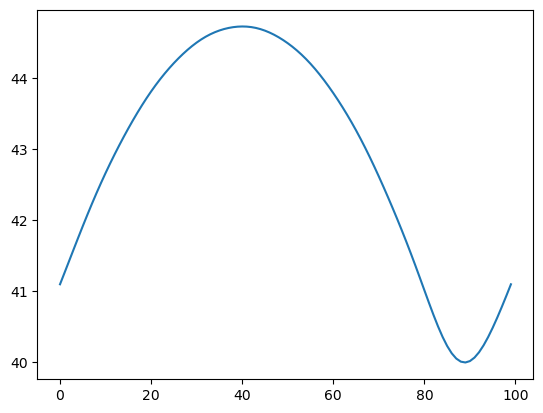

In [17]:
def mean_radius(model):
    return np.mean(np.linalg.norm(model.centers[model.mus>0], axis=1))

plt.plot([mean_radius(m) for m in mb_ps])

Text(0.5, 0, 'Phase')

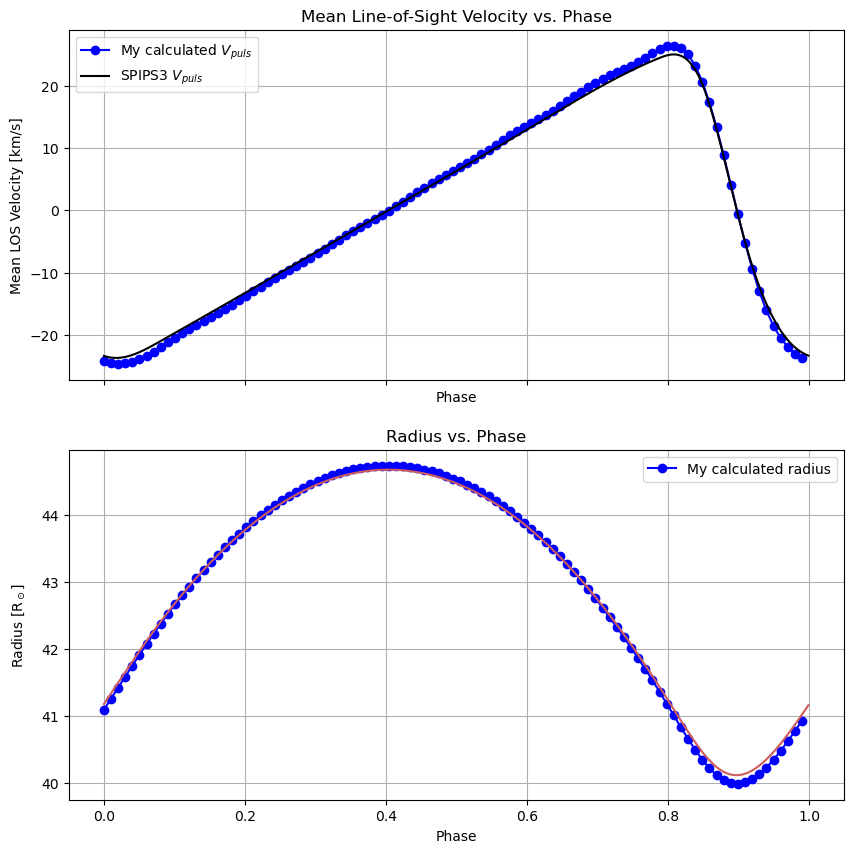

In [18]:
# Create a figure to plot the mean line-of-sight velocities over time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Calculate the mean line-of-sight velocities for each time step
pulsation_velocities = np.array([calculate_mean_rad_vel(m) for m in mb_ps])

# Convert time to phase for plotting
phases = (timeseries / period) % 1.0

# Plot the mean line-of-sight velocities
ax[0].plot(phases[:-1], pulsation_velocities[:-1], 'o-', color='blue', label=r'My calculated $V_{puls}$')
ax[0].plot(pulsation_data['PHASE'], pulsation_data['Vpuls'], color='black', label=r'SPIPS3 $V_{puls}$')
ax[0].set_xlabel('Phase')
ax[0].set_ylabel('Mean LOS Velocity [km/s]')
ax[0].set_title('Mean Line-of-Sight Velocity vs. Phase')
ax[0].grid(True)
ax[0].legend()
# Plot the mean radius from my calculated data
ax[1].plot(phases[:-1], np.array([mean_radius(m) for m in mb_ps])[:-1], 'o-', color='blue', label='My calculated radius')
ax[1].set_title('Radius vs. Phase')
ax[1].legend()


ax[1].plot(pulsation_data['PHASE'], pulsation_data['R'], color='indianred')
ax[1].grid(True)
ax[1].set_ylabel(r'Radius [R$_\odot$]', labelpad=10)
ax[1].set_xlabel('Phase')

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
/jobfs/144999564.gadi-pbs/ipykernel_1138398/587135505.py:23: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Mean Radius Offset [$R_\odot$]')


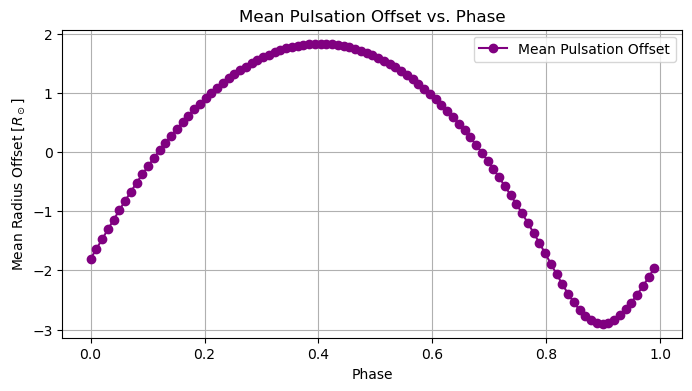

In [19]:
# Plot the mean pulsation offsets (radius change) over phase

def calculate_mean_pulsation_offset(model):
    # Calculate the magnitude of pulsation offset vectors
    offset_magnitudes = np.sqrt(model.center_pulsation_offsets[model.mus>0, 0]**2 + model.center_pulsation_offsets[model.mus>0, 1]**2 + model.center_pulsation_offsets[model.mus>0, 2]**2)
    
    # Determine sign based on radial component (negative = contracting, positive = expanding)
    # For a spherical model, we can use the dot product with normalized position vectors
    normalized_positions = model.centers[model.mus>0] / np.linalg.norm(model.centers[model.mus>0], axis=1)[:, np.newaxis]
    radial_components = np.sum(model.center_pulsation_offsets[model.mus>0] * normalized_positions, axis=1)
    
    # Apply sign to magnitudes
    signed_offsets = np.sign(radial_components) * offset_magnitudes
    return np.max(signed_offsets)

# Compute the magnitude of the mean offset vector for each phase
mean_radius_offset_magnitude = np.array([calculate_mean_pulsation_offset(_m) for _m in mb_ps])

# Plot the mean pulsation offset as a function of phase
plt.figure(figsize=(8, 4))
plt.plot(phases[:-1], mean_radius_offset_magnitude[:-1], 'o-', color='purple', label='Mean Pulsation Offset')
plt.xlabel('Phase')
plt.ylabel('Mean Radius Offset [$R_\odot$]')
plt.title('Mean Pulsation Offset vs. Phase')
plt.grid(True)
plt.legend()
plt.show()

## $T_{eff}$ and log g modification

Let's now modify the mesh properties according to the template from SPIPS3. **Note we have to interpolate the functions, since SPIPS3 contains data for 1000 phases, and our sampling is sparser**. 

In [20]:
from spice.utils.parameters import modify_mesh_parameter_from_array
# Create interpolation functions for Teff and logg based on phase
from scipy.interpolate import interp1d

# Extract phase, Teff, and logg data from pulsation_data
phase_data = pulsation_data['PHASE'].data
teff_data = pulsation_data['Teff'].data
logg_data = pulsation_data['logg'].data

# Ensure phase data is sorted for interpolation
sort_idx = np.argsort(phase_data)
sorted_phase = phase_data[sort_idx]
sorted_teff = teff_data[sort_idx]
sorted_logg = logg_data[sort_idx]

# Create interpolation functions
# Use 'cubic' for smooth interpolation and 'period=1' since phase wraps around
teff_interp = interp1d(sorted_phase, sorted_teff, kind='cubic', bounds_error=False, 
                      fill_value=(sorted_teff[-1], sorted_teff[0]), assume_sorted=True)
                      
logg_interp = interp1d(sorted_phase, sorted_logg, kind='cubic', bounds_error=False,
                      fill_value=(sorted_logg[-1], sorted_logg[0]), assume_sorted=True)

# Function to get Teff and logg at any phase
def get_teff_at_phase(phase):
    phase = phase % 1.0
    return teff_interp(phase)

def get_logg_at_phase(phase):
    phase = phase % 1.0
    return logg_interp(phase)
    

# Calculate phase from timestamps and period
phases = [(t % period) / period for t in timeseries]

mb_ps = [modify_mesh_parameter_from_array(_mp, 0, get_teff_at_phase(phase)) for _mp, phase in zip(mb_ps, phases)]
mt_ps = [modify_mesh_parameter_from_array(_mp, 0, jnp.log10(get_teff_at_phase(phase))) for _mp, phase in zip(mt_ps, phases)]
mt_ps = [modify_mesh_parameter_from_array(_mp, 1, get_logg_at_phase(phase)) for _mp, phase in zip(mt_ps, phases)]

/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


## Synthetic spectra timeseries

In [24]:
from spice.spectrum import simulate_observed_flux

LINE_CENTERS = [4896.439, 5049.82, 5044.21, 4924.77, 6347, 6371]
LINE_WIDTH = 2
STEPS = 2000
LINE_NAMES = ['Fe I', 'Fe I', 'Fe I', 'Fe I', 'Si II', 'Si II']
vws = []
spectra = []
templates = []

for lc in tqdm(LINE_CENTERS, desc='Going over lines', leave=False):
    vws.append(jnp.linspace(lc-LINE_WIDTH, lc+LINE_WIDTH, STEPS))
    
    # Simulate spectra for the current line center across all mesh parameters
    current_line_spectra = []
    for _mp in tqdm(mt_ps, desc=f'Simulating spectra for line {lc:.2f}', leave=False):
        flux = simulate_observed_flux(tp.intensity, _mp, jnp.log10(vws[-1]))
        current_line_spectra.append(flux)
    spectra.append(current_line_spectra)
    
    # Simulate template spectrum for the current line center
    templates.append(simulate_observed_flux(tp.intensity, mt, jnp.log10(vws[-1])))

In [46]:
import pickle
import os

# Define the output directory and filename
output_dir = './' # Or specify a different directory if needed
filename = os.path.join(output_dir, 'cepheid_spectra_data.pkl')

print(f"Saving spectra data to {filename}...")

# Data to save
data_to_save = {
    'spectra': spectra,
    'vws': vws,
    'templates': templates
}

# Save the data using pickle
with open(filename, 'wb') as f:
    pickle.dump(data_to_save, f)

print("Data saved successfully.")


Saving spectra data to ./cepheid_spectra_data.pkl...
Data saved successfully.


In [37]:
# Calculate radial velocity using cross-correlation function
import numpy as np
from scipy.signal import correlate
from scipy.interpolate import interp1d

# Function to calculate radial velocity using cross-correlation
def calculate_radial_velocity(template_spectrum, observed_spectrum, wavelengths, velocity_range=(-100, 100), num_velocities=200):
    """
    Calculate radial velocity using cross-correlation between template and observed spectrum.
    
    Parameters:
    -----------
    template_spectrum : array-like
        Reference spectrum (flux values)
    observed_spectrum : array-like
        Observed spectrum to measure velocity (flux values)
    wavelengths : array-like
        Wavelength array in Angstroms
    velocity_range : tuple
        Min and max velocity to search in km/s
    num_velocities : int
        Number of velocity points to test
        
    Returns:
    --------
    best_velocity : float
        Radial velocity in km/s
    ccf : array
        Cross-correlation function
    velocities : array
        Velocity grid used for cross-correlation
    """
    # Create velocity grid
    velocities = np.linspace(velocity_range[0], velocity_range[1], num_velocities)
    
    # Speed of light in km/s
    c = 299792.458
    
    # Normalize spectra to have zero mean and unit variance
    template_norm = (template_spectrum - np.mean(template_spectrum)) / np.std(template_spectrum)
    observed_norm = (observed_spectrum - np.mean(observed_spectrum)) / np.std(observed_spectrum)
    
    # Calculate cross-correlation for each velocity shift
    ccf = np.zeros(len(velocities))
    
    for i, v in enumerate(velocities):
        # Calculate wavelength shift for this velocity
        doppler_factor = np.sqrt((1 + v/c) / (1 - v/c))  # Relativistic Doppler formula
        shifted_wavelengths = wavelengths * doppler_factor
        
        # Interpolate the template onto the shifted wavelength grid
        shifted_template = interp1d(shifted_wavelengths, template_norm, 
                                    bounds_error=False, fill_value=0)(wavelengths)
        
        # Calculate correlation
        ccf[i] = np.sum(shifted_template * observed_norm)
    
    # Find the velocity with maximum correlation
    best_idx = np.argmax(ccf)
    best_velocity = -velocities[best_idx]  # Flip the sign of the velocity
    
    return best_velocity, ccf, velocities


In [45]:
radial_velocities = []
for j in tqdm(range(len(LINE_CENTERS[:2])), desc='Going over lines'):
# Use the first spectrum as a template
    template_spectrum = templates[j][:, 0]/templates[j][:, 1]

    # Calculate radial velocities for all spectra
    _radial_velocities = []
    for i, spectrum in enumerate(spectra[j]):
        if i == 0:  # Skip the template
            _radial_velocities.append(0.0)
            continue
            
        rv, ccf, velocities = calculate_radial_velocity(
            template_spectrum, 
            spectrum[:, 0]/spectrum[:, 1], 
            vws[j], 
            velocity_range=(-50, 50)
        )
        _radial_velocities.append(rv)
    radial_velocities.append(_radial_velocities)

Going over lines:   0%|                                                                                                                                          | 0/2 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [44]:
radial_velocities = np.array(radial_velocities)
radial_velocities.shape

(2, 99, 201)

In [33]:
import cmasher as cmr
# Plot radial velocity curve
cmap = cmr.bubblegum
plt.figure(figsize=(10, 6))
plt.scatter(phases[1:], radial_velocities[0][1:], c=phases[1:], cmap=cmap, s=50)
plt.colorbar(label='Phase')
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km/s)')
plt.title('Radial Velocity Curve')
plt.grid(True, alpha=0.3)
plt.show()

# # Plot a sample cross-correlation function
# sample_idx = 10  # Choose a sample spectrum
# rv, ccf, velocities = calculate_radial_velocity(
#     template_spectrum, 
#     spectra[sample_idx][:, 0], 
#     vws, 
#     velocity_range=(-50, 50)
# )

TypeError: 'float' object is not subscriptable

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pickle

# Create a dictionary to store the data
data_dict = {
    'spectra': spectra,
    'phases': phases,
    'radial_velocities': radial_velocities,
    'pulsation_velocities': pulsation_velocities,
    'template_spectrum': template_spectrum
}

# Save to pickle file
with open('cepheid_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

print("Data saved to cepheid_data.pkl")


In [ ]:
def calculate_max_rad_vel(model):
    # Calculate the magnitude of velocity vectors
    velocity_magnitudes = np.sqrt(model.pulsation_velocities[model.mus>0, 0]**2 + model.pulsation_velocities[model.mus>0, 1]**2 + model.pulsation_velocities[model.mus>0, 2]**2)
    
    # Determine sign based on radial component (negative = contracting, positive = expanding)
    # For a spherical model, we can use the dot product with normalized position vectors
    normalized_positions = model.centers[model.mus>0] / np.linalg.norm(model.centers[model.mus>0], axis=1)[:, np.newaxis]
    radial_components = np.sum(model.pulsation_velocities[model.mus>0] * normalized_positions, axis=1)
    
    # Apply sign to magnitudes
    signed_velocities = np.sign(radial_components) * velocity_magnitudes
    return np.max(signed_velocities)

In [ ]:
plt.plot(phases[1:-1], radial_velocities[1:-1], c='royalblue', marker='o', label='Measured Radial Velocity')
pulsation_velocities = np.array([calculate_max_rad_vel(m) for m in mb_ps])
plt.plot(phases[1:-1], pulsation_velocities[1:-1], c='coral', marker='o', label='True Pulsation Radial Velocity')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km/s)')
plt.legend()

In [ ]:
np.nanmean(np.array([calculate_max_rad_vel(m) for m in mb_ps])[1:]/radial_velocities[1:])

In [ ]:
import numpy as np
from scipy.signal import correlate

# Speed of light in km/s
c = 299792.458  # km / s

def radial_velocity_ccf(wave: np.ndarray, flux: np.ndarray, template_wave: np.ndarray, template_flux: np.ndarray):
    """
    Compute radial velocity shift between spectrum and template using cross-correlation.

    Parameters
    ----------
    wave : ndarray
        Wavelength array of the spectrum (Angstroms).
    flux : ndarray
        Flux array of the spectrum (continuum-normalized).
    template_wave : ndarray
        Wavelength array of the template spectrum (Angstroms).
    template_flux : ndarray
        Flux array of the template spectrum (continuum-normalized).

    Returns
    -------
    rv : float
        Radial velocity shift (km / s).
    ccf : ndarray
        Cross-correlation function values.
    dv : float
        Velocity increment per pixel in the CCF (km / s).
    """
    # Natural logarithm of wavelengths
    ln_wave = np.log(wave)
    ln_template = np.log(template_wave)
    # Define common log-wavelength grid
    ln_min = max(ln_wave.min(), ln_template.min())
    ln_max = min(ln_wave.max(), ln_template.max())
    n_points = len(ln_wave)
    ln_grid = np.linspace(ln_min, ln_max, n_points)
    # Velocity increment per pixel: Δlnλ * c
    delta_ln = ln_grid[1] - ln_grid[0]
    dv = delta_ln * c
    # Interpolate spectra onto the log-wavelength grid
    flux_i = np.interp(ln_grid, ln_wave, flux)
    template_i = np.interp(ln_grid, ln_template, template_flux)
    # Subtract mean to remove continuum
    flux_i -= np.mean(flux_i)
    template_i -= np.mean(template_i)
    # Compute cross-correlation
    ccf = correlate(flux_i, template_i, mode='same')
    # Find shift index relative to zero lag
    shift_index = np.argmax(ccf) - (len(ccf) // 2)
    # Compute radial velocity
    rv = shift_index * dv
    return rv, ccf, dv

# Example usage (replace with actual data arrays):
# timeseries_waves = [wave1, wave2, ...]            # lists of numpy arrays in Angstroms
# timeseries_fluxes = [flux1, flux2, ...]           # lists of continuum-normalized flux arrays
# template_wave, template_flux                      # numpy arrays as reference spectrum

# rvs = []
# for flux in spectra:
#     rv, ccf, dv = radial_velocity_ccf(vws, flux[:, 0]/flux[:, 1], vws, spectra[0][:, 0]/spectra[0][:, 1])
#     rvs.append(rv)
# print("Radial velocities (km/s):", np.array(rvs))


In [ ]:
# Create a colormap for phases
import matplotlib.cm as cm
import cmasher as cmr
import matplotlib.pyplot as plt
cmap = cmr.bubblegum

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

# Plot spectra colored by phase
for i, s in enumerate(spectra):
    # Normalize phase to [0, 1] for color mapping
    phase_normalized = phases[i] % 1.0
    color = cmap(phase_normalized)
    ax.plot(vws, s[:, 0]/s[:, 1], color=color, alpha=0.7)

# Add a colorbar to show phase mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Explicitly provide the axis to steal space from
cbar.set_label('Phase')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Normalized spectrum');

In [ ]:
from spice.plots.plot_mesh import animate_mesh_and_spectra

animate_mesh_and_spectra(mt_ps, np.array(spectra)[:, :, 0]/np.array(spectra)[:, :, 1], vws, property=0, property_label=r'T [K]',
                         filename='cepheid_spectra_animation_closeup.gif');

In [ ]:
from spice.spectrum import simulate_observed_flux
vws = jnp.linspace(3000, 9000, 40000)

spectra_broad = [simulate_observed_flux(tp.intensity, _mp, jnp.log10(vws)) for _mp in tqdm(mt_ps, desc='Simulating spectra')]

In [ ]:
import pickle

# Save spectra_broad to a pickle file
with open('delta_cephei_spectra_broad.pkl', 'wb') as f:
    pickle.dump(spectra_broad, f)


In [ ]:
import pickle

spectra_broad = pickle.load(open('delta_cephei_spectra_broad.pkl', 'rb'))
vws = jnp.linspace(3000, 9000, 40000)

In [ ]:
# Create a colormap for phases
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cmasher as cmr
cmap = cmr.bubblegum

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

for i, s in enumerate(spectra_broad):
    # Normalize phase to [0, 1] for color mapping
    phase_normalized = phases[i] % 1.0
    color = cmap(phase_normalized)
    ax.plot(vws, s[:, 0], color=color, alpha=0.7)

# Add a colorbar to show phase mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Explicitly provide the axis to steal space from
cbar.set_label('Phase')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux')
ax.set_title('Spectra at Different Phases')

In [ ]:
spectra_broad = np.array(spectra_broad)
spectra_broad.shape

In [ ]:
# Define the wavelength range for the Calcium Triplet
ca_triplet_min_wl = 8450
ca_triplet_max_wl = 8700

# Find the indices corresponding to this wavelength range
ca_triplet_indices = jnp.where((vws >= ca_triplet_min_wl) & (vws <= ca_triplet_max_wl))[0]
ca_triplet = spectra_broad[:, ca_triplet_indices, :]
ca_triplet.shape

In [ ]:
for s in ca_triplet:
    plt.plot(s[:, 0]/s[:, 1])
plt.show()

In [ ]:
import pickle

# Save spectra_broad to a pickle file
with open('delta_cephei_spectra_broad.pkl', 'rb') as f:
    spectra_broad = pickle.load(f)

In [ ]:
vws = jnp.linspace(3000, 9000, 40000)

In [ ]:
from spice.spectrum.filter import Bolometric, JohnsonCousinsV, JohnsonCousinsR, GaiaG, TychoBT, TychoVT
from spice.spectrum.spectrum import AB_passband_luminosity
# b = Bolometric()
# bolometric_lum = [AB_passband_luminosity(b, vws, s[:, 0]) for s in spectra_broad]
johnson_v = JohnsonCousinsV()
johnson_r = JohnsonCousinsR()
gaia_g = GaiaG()
tycho_bt = TychoBT()
tycho_vt = TychoVT()
v_lum = [AB_passband_luminosity(johnson_v, vws, s[:, 0]) for s in spectra_broad]
r_lum = [AB_passband_luminosity(johnson_r, vws, s[:, 0]) for s in spectra_broad]
g_lum = [AB_passband_luminosity(gaia_g, vws, s[:, 0]) for s in spectra_broad]
bt_lum = [AB_passband_luminosity(tycho_bt, vws, s[:, 0]) for s in spectra_broad]
vt_lum = [AB_passband_luminosity(tycho_vt, vws, s[:, 0]) for s in spectra_broad]

In [ ]:
v_lum

In [ ]:
import cmasher as cmr
colors = cmr.neon(np.linspace(0, 1, 5))

plt.plot(phases[:-1], np.array(v_lum[:-1])-v_lum[0], color=colors[0], label='Johnson Cousins V', linewidth=3, linestyle='dotted')
plt.plot(phases[:-1], np.array(r_lum[:-1])-r_lum[0], color=colors[1], label='Johnson Cousins R', linewidth=3)
plt.plot(phases[:-1], np.array(g_lum[:-1])-g_lum[0], color=colors[2], label='Gaia G', linewidth=3, linestyle='--')
plt.plot(phases[:-1], np.array(bt_lum[:-1])-bt_lum[0], color=colors[3], label='Tycho BT', linewidth=3, linestyle='-.')
plt.plot(phases[:-1], np.array(vt_lum[:-1])-vt_lum[0], color=colors[4], label='Tycho VT', linewidth=3)
plt.legend();
plt.gca().invert_yaxis();
plt.xlabel('Phase');
plt.ylabel('[mag]')

In [ ]:
obs_phases.keys()

In [ ]:
v_filter_key = 'V_GCPD_Johnson'
plt.plot(phases[:-1], np.array(v_lum[:-1])-np.array(v_lum[0]), color='indianred')
plt.xlabel('Phase')
plt.ylabel(r'Johnson V $\Delta$ Luminosity [mag]')
plt.legend();
plt.scatter(obs_phases[v_filter_key], obs_magnitudes[v_filter_key]-obs_magnitudes[v_filter_key][0], 
           color='black', label='Observed Johnson Cousins V', alpha=0.5)
plt.errorbar(obs_phases[v_filter_key], obs_magnitudes[v_filter_key]-obs_magnitudes[v_filter_key][0],
             yerr=obs_magnitudes_err[v_filter_key], color='black', fmt='none')
plt.gca().invert_yaxis();